## Starfysh tutorial

#### Azizi Lab

Siyu He, Yinuo Jin

06-12-2022

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context

## load starfysh

In [3]:
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      dataloader,
                      post_analysis
                      )

## load data and gene signature

In [4]:
# set the data folder
if IN_COLAB:
    data_folder = '/content/drive/MyDrive/SpatialModelProject/data'
else:
    data_folder = 'data/'

In [5]:
## load data and gene signature
sample_id='MBC_1A' # , CID444971, CID4465, CID4290, CID4535, 1142243F, 1160920F
sig_file_name = 'bc_signatures_version_0201.csv'

adata_sample, adata_sample_normed = utils.load_adata(data_folder,sample_id,n_genes=2000)
gene_sig = pd.read_csv(os.path.join(data_folder,sig_file_name))

## filter the low expressed genes
gene_sig = utils.filter_gene_sig(gene_sig,adata_sample.to_df())

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Preprocessing1: delete the mt and rp
Preprocessing2: Normalize


/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


## get library size

In [6]:
if data_folder =='simu_data':
    map_info = utils.get_simu_map_info(umap_df)
else:
    #adata_image, adata_image_h, adata_image_e,map_info = utils.preprocess_img(data_folder,sample_id,adata_sample.obs.index,hchannal=False)
    adata_image,map_info = utils.preprocess_img(data_folder,sample_id,adata_sample.obs.index,hchannal=False)

log_lib = np.log((adata_sample.to_df()).sum(axis=1))
win_loglib = utils.get_windowed_library(adata_sample,
                                  map_info,
                                  log_lib,
                                  window_size=3
                                 )

/Users/siyuhe/03_Spatial_project/starfysh/utils.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_info.loc[:,'imagerow'] = tissue_position_list.iloc[:,3] *tissue_hires_scalef
/Users/siyuhe/03_Spatial_project/starfysh/utils.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_info.loc[:,'imagecol'] = tissue_position_list.iloc[:,4] *tissue_hires_scalef


## plot log lib

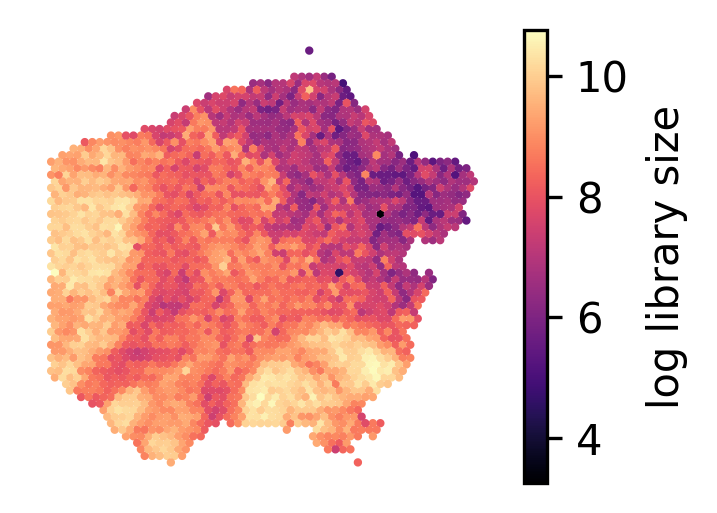

In [7]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 log_lib,
                 label='log library size'
                )

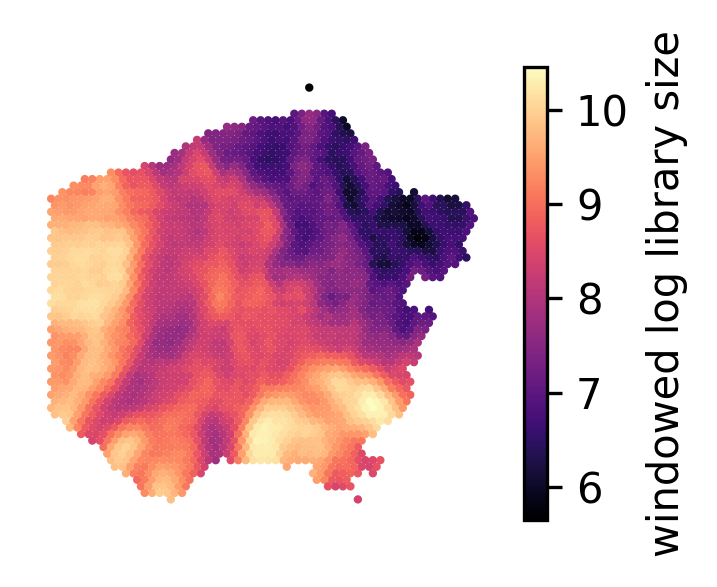

In [8]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 win_loglib,
                 label='windowed log library size'
                )

## plot raw gene expression

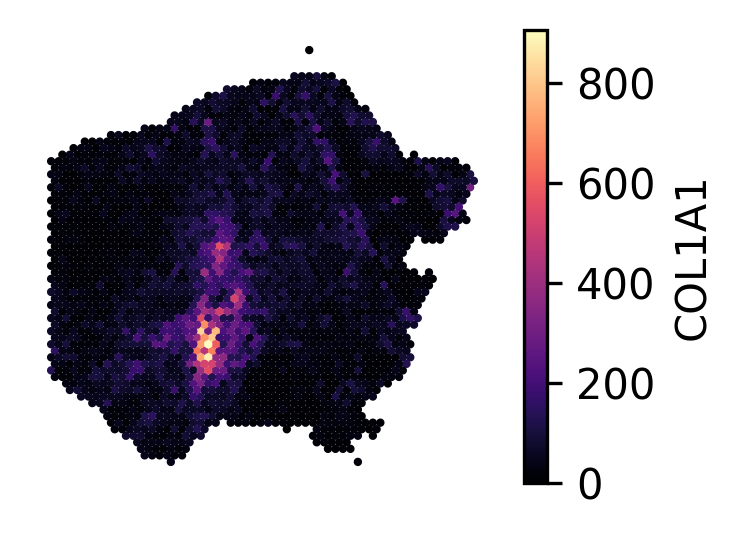

In [9]:
plot_gene_name = 'COL1A1'
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 adata_sample.to_df().loc[:,plot_gene_name],
                 label=plot_gene_name
                )

## prepare input (prior, anchor spots and data)

In [10]:
# make sure the signature gene name is matched with expression matrix
adata_sample = utils.get_adata_wsig(adata_sample, gene_sig)
adata_sample_normed = utils.get_adata_wsig(adata_sample_normed, gene_sig)

# make sure the signature gene name is matched with expression matrix
#sig_mean = utils.get_sig_mean(adata_sample, gene_sig, log_lib)
sig_mean = utils.get_sig_mean(adata_sample, gene_sig, log_lib)
#sig_mean = sig_mean.fillna(0)

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (621,)
after filter out some genes in the signature not in the var_names ... (589,)
after filter out some genes not highly expressed in the signature ... (589,)
combine the varibale and siganture, the total unique gene number is ... 2473
the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (621,)
after filter out some genes in the signature not in the var_names ... (589,)
after filter out some genes not highly expressed in the signature ... (589,)
combine the varibale and siganture, the total unique gene number is ... 2473


In [11]:
from scipy.stats import zscore
sig_mean = sig_mean+1e-12
sig_mean_zscore = sig_mean.apply(zscore,axis=0)
sig_mean_zscore[sig_mean_zscore<0]=0 
#sig_mean_zscore = sig_mean_zscore-sig_mean_zscore.min()
sig_mean_zscore = sig_mean_zscore.fillna(0)

In [12]:
pure_spots, pure_dict, pure_idx = utils.get_anchor_spots(adata_sample,
                                               sig_mean_zscore,#sig_mean_zscore,
                                               v_low = 10,#10, 
                                               v_high = 95,#99,
                                               n_anchor = 60#60
                                              )

/Users/siyuhe/03_Spatial_project/starfysh/utils.py:244: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pure_spots = np.transpose(sig_mean.loc[highq_spots,:].index[(-np.array(sig_mean.loc[highq_spots,:])).argsort(axis=0)[:n_anchor,:]])


## plot anchor spots

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new C

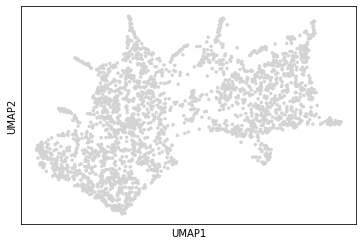

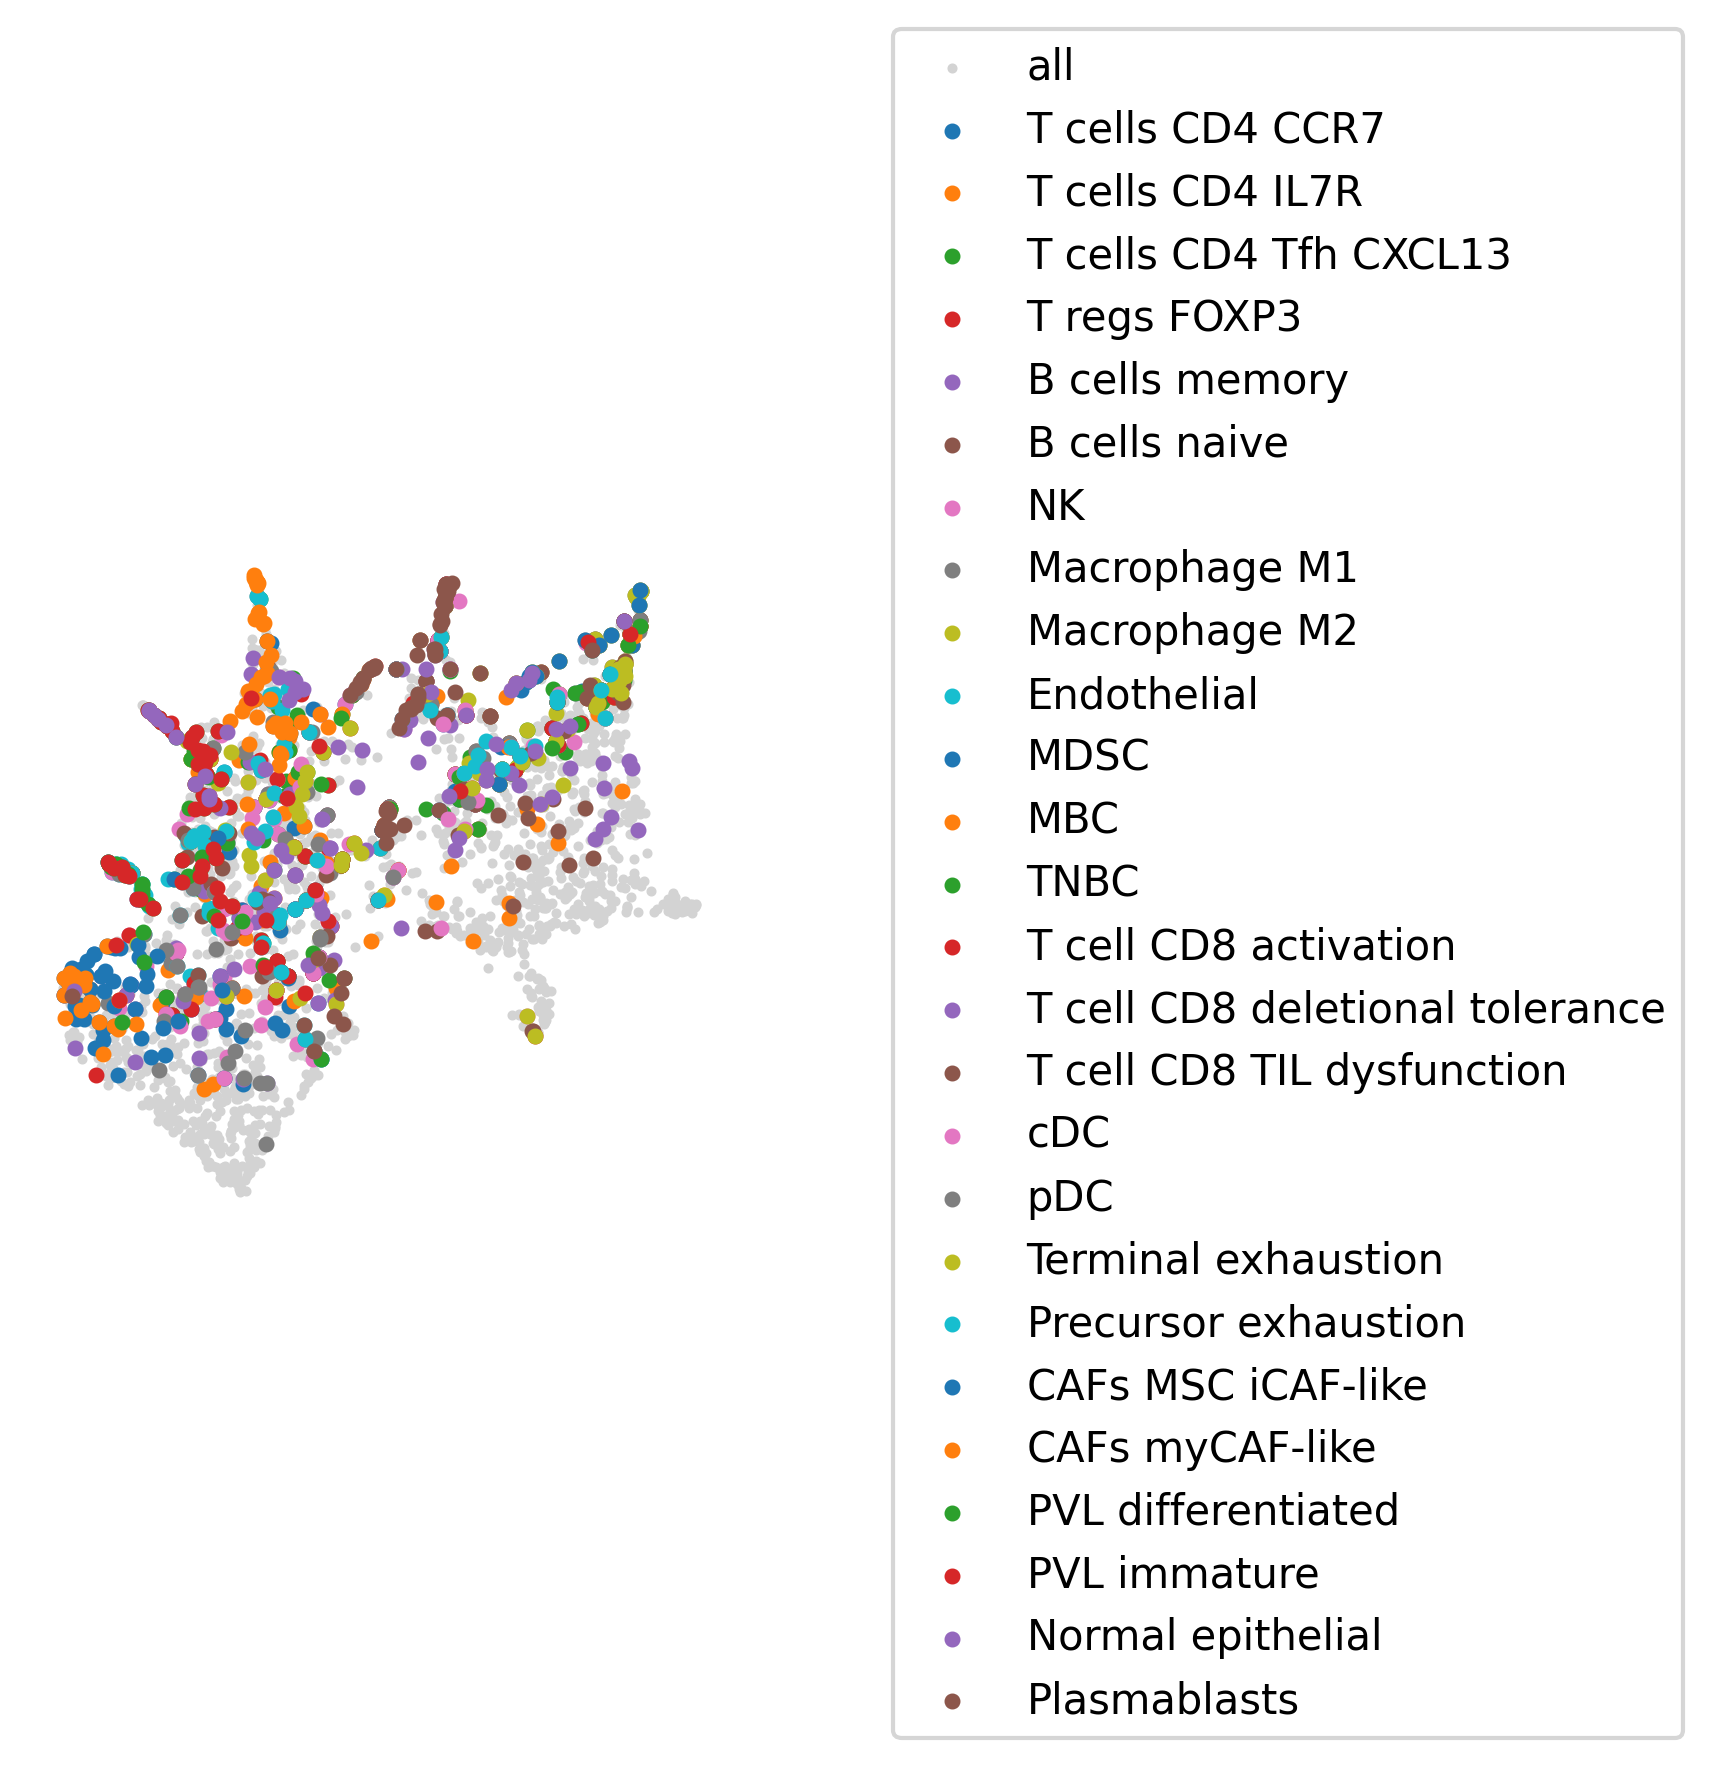

In [13]:
umap_df = utils.get_umap(adata_sample)
plot_utils.plot_anchor_spots(umap_df,pure_spots,sig_mean,bbox_x=2.4)

## Run starfysh

In [14]:
alpha_min = 0
for col_idx in np.array(sig_mean.columns):
    if (1/(sig_mean.loc[pure_dict[col_idx],:]/sig_mean.loc[pure_dict[col_idx],:].sum())[col_idx]).max()>alpha_min:
        alpha_min = (1/(sig_mean.loc[pure_dict[col_idx],:]/sig_mean.loc[pure_dict[col_idx],:].sum())[col_idx]).max()


model = starfysh.AVAE(
            adata = adata_sample,
            gene_sig = gene_sig,
            alpha_min = alpha_min,
            win_loglib = win_loglib,
          )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

trainset = dataloader.VisiumDataset(adata=adata_sample, 
                                    gene_sig_exp_m=sig_mean_zscore,#sig_mean_zscore,
                                    adata_pure = pure_idx,
                                    library_n = win_loglib
                                    )

trainloader = DataLoader(trainset, 
                         batch_size=32, 
                         shuffle=True)

epochs= 30
train_loss = []
corr_list_all = []
for epoch in range(epochs):
    (train_epoch_loss, 
     train_reconst, 
     train_z, 
     train_c, 
     train_n, 
     corr_list) = starfysh.train(model, 
                                 trainloader, 
                                 trainset, 
                                 device, 
                                 optimizer)
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    corr_list_all.append(corr_list)
    if (epoch+1) % 1 == 0:
            print ("Epoch[{}/{}], train_loss: {:.4f}, train_reconst: {:.4f}, train_z: {:.4f},train_c: {:.4f},train_n: {:.4f}".format(epoch+1, epochs, train_epoch_loss, train_reconst, train_z, train_c, train_n))  
print('finish lower training rate')

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'starfysh.starfysh.NegBinom'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch[1/30], train_loss: 3348.1134, train_reconst: 1513.4022, train_z: 19.6669,train_c: 1767.4748,train_n: 47.5694
Epoch[2/30], train_loss: 2277.7976, train_reconst: 1192.9681, train_z: 20.9315,train_c: 1017.8443,train_n: 46.0538
Epoch[3/30], train_loss: 1975.3888, train_reconst: 1170.0678, train_z: 18.7357,train_c: 743.7838,train_n: 42.8015
Epoch[4/30], train_loss: 1757.2953, train_reconst: 1151.3519, train_z: 16.9503,train_c: 548.5975,train_n: 40.3956
Epoch[5/30], train_loss: 1673.0736, train_reconst: 1141.7066, train_z: 16.0753,train_c: 476.2830,train_n: 39.0087
Epoch[6/30], train_loss: 1610.7669, train_reconst: 1132.2584, train_z: 15.6892,train_c: 424.6431,train_n: 38.1762
Epoch[7/30], train_loss: 1633.0581, train_reconst: 1126.0689, train_z: 15.0654,train_c: 454.4700,train_n: 37.4538
Epoch[8/30], train_loss: 1573.8003, train_reconst: 1120.5606, train_z: 14.5246,train_c: 402.1621,train_n: 36.5529
Epoch[9/30], train_loss: 1520.5769, train_reconst: 1115.6303, train_z: 13.9853,train_c

## Basic downstream analysis

In [15]:
lib_low=torch.exp(torch.Tensor([5.0])).to(device)
inference_outputs, generative_outputs, px = starfysh.model_eval(model,adata_sample, sig_mean, device,log_lib,lib_low)
u = post_analysis.get_z_umap(inference_outputs)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

/Users/siyuhe/03_Spatial_project/starfysh/starfysh.py:472: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  library_i = torch.Tensor(library_i[:,None])


#### 1. gene sig mean vs. inferred prop

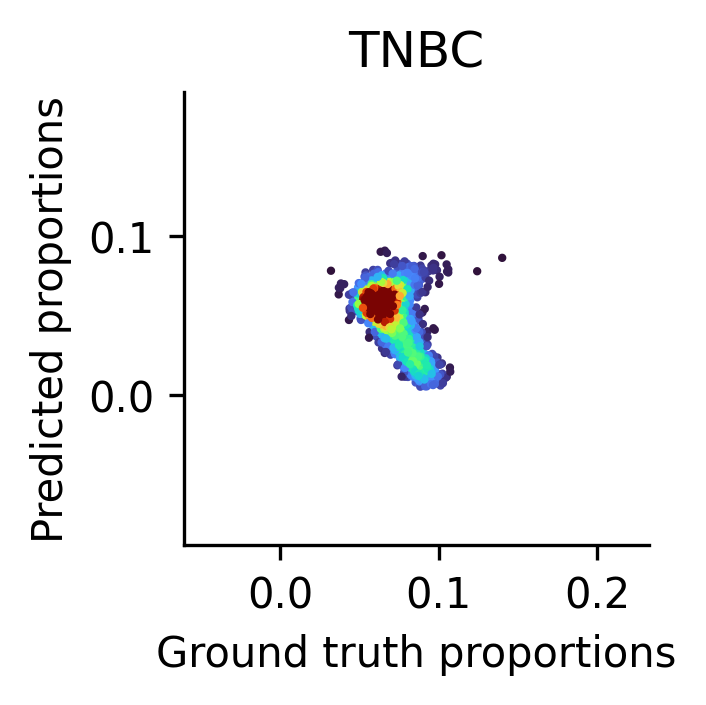

In [16]:
sig_mean_n_df = pd.DataFrame(np.array(sig_mean)/(np.sum(np.array(sig_mean),axis=1,keepdims=True)+1e-5),
                                 columns=sig_mean.columns,
                                 index = sig_mean.index
                                )
post_analysis.pred_prop_scatter(inference_outputs,
                                    sig_mean_n_df,
                                    idx=12)

#### 2. inferred density

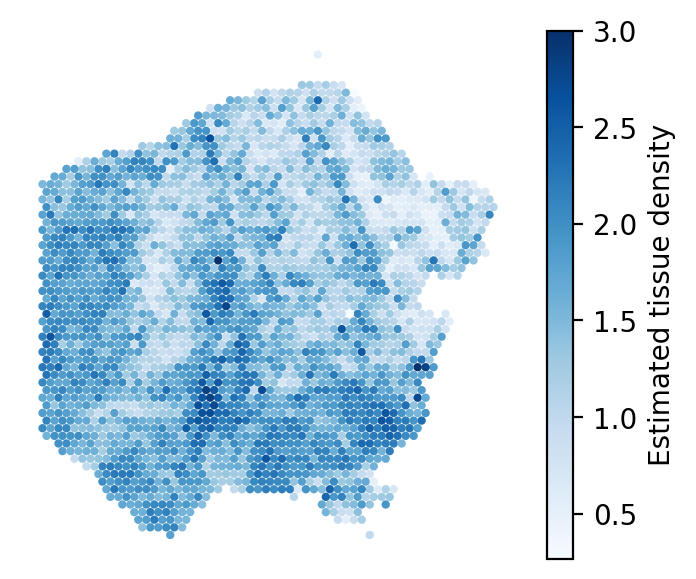

In [17]:
plot_utils.pl_spatial_inf_feature(adata_sample,
                   map_info,
                   inference_outputs,
                   feature='ql_m',
                   idx=0,
                   plt_title='',
                   label='Estimated tissue density',
                   s=4,
                   vmax=3
                   )

#### 3. inferred prop. on umap (adjust idx number for different cell types)

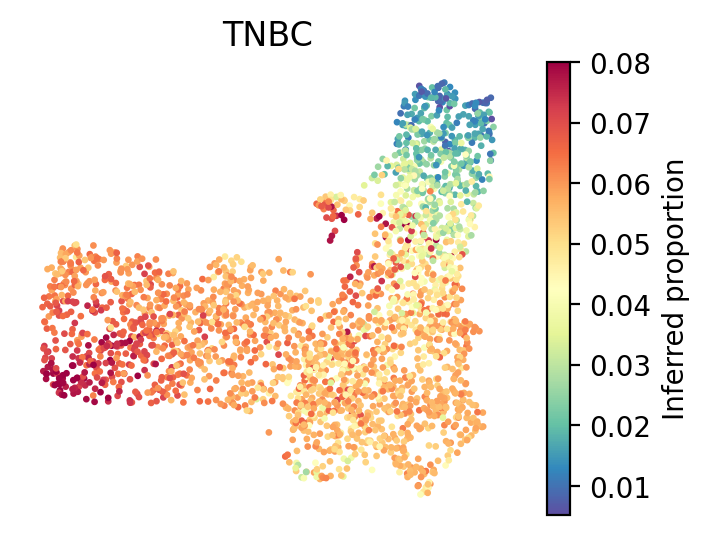

In [20]:
idx=12



plot_utils.pl_umap_feature(adata_sample,
                   u,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),#/np.sum(np.array(sig_mean),axis=1,keepdims=True),
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=2,
                   vmax=0.08
                   )

#### 4. inferred prop. on spatial loc (adjust idx number for different cell types)

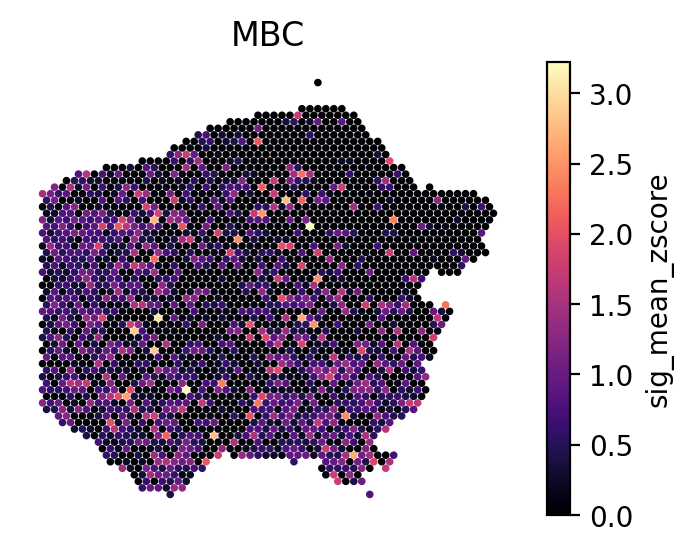

In [21]:
from scipy import stats
idx=11


plot_utils.pl_spatial_feature(adata_sample,
                   map_info,
                   feature=np.array(sig_mean_zscore),
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='sig_mean_zscore',
                   s=3,
                   #vmax=3
                   )

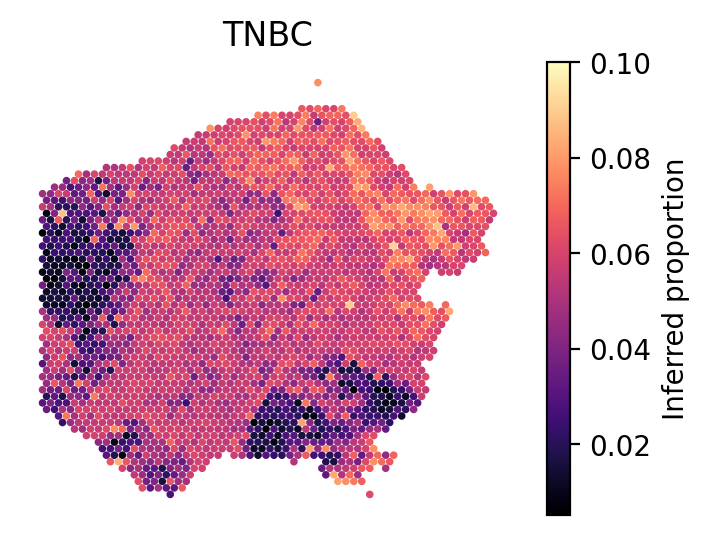

In [27]:
idx=12




plot_utils.pl_spatial_feature(adata_sample,
                   map_info,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=3,
                   vmax=0.1
                   )

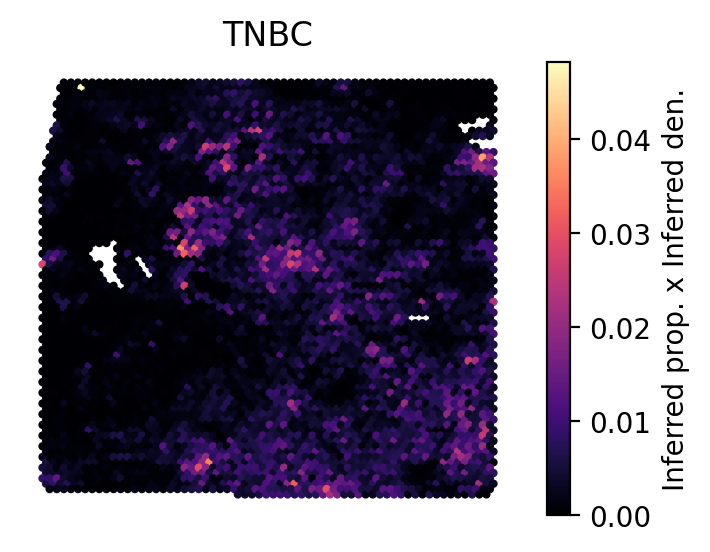

In [24]:
idx=12
ql_m_norm = np.exp(inference_outputs['ql_m'].detach().cpu().numpy())
ql_m_norm = (ql_m_norm-ql_m_norm.min())/(ql_m_norm.max()-ql_m_norm.min())
                   
plot_utils.pl_spatial_feature(adata_sample,
                   map_info,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy())*ql_m_norm,
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred prop. x Inferred den.',
                   s=4,
                   #vmax=0.005
                   )

In [25]:
model.alpha

Parameter containing:
tensor([493.4308, 765.6318,  85.6390, 129.2301, 305.0696, 631.5034, 487.8884,
        894.0419, 453.0090, 629.7589, 346.3988, 398.8562,  19.8049, 166.3984,
        291.2385, 515.5988, 695.2393, 797.5330, 158.5914, 279.5571, 679.0295,
        913.6750, 394.8293, 871.9681, 416.9002, 550.4375], requires_grad=True)

In [26]:
dist = {
        'px_rate': generative_outputs['px_rate'].detach().cpu().numpy().tolist(),
        'px_r': generative_outputs['px_r'].detach().cpu().numpy().tolist(),
        'pc_p': generative_outputs['pc_p'].detach().cpu().numpy().tolist(),

        'qc_m': inference_outputs['qc_m'].detach().cpu().numpy().tolist(),
        'qc': inference_outputs['qc'].detach().cpu().numpy().tolist(),
        'qz_m': inference_outputs['qz_m'].detach().cpu().numpy().tolist(),
        'qz_m_ct': inference_outputs['qz_m_ct'].detach().cpu().numpy().tolist(),
        'qz_logv': inference_outputs['qz_logv'].detach().cpu().numpy().tolist(),
        'qz_logv_ct': inference_outputs['qz_logv_ct'].detach().cpu().numpy().tolist(),
        'qz': inference_outputs['qz'].detach().cpu().numpy().tolist(),
        'ql_m': inference_outputs['ql_m'].detach().cpu().numpy().tolist(),
        'ql_logv': inference_outputs['ql_logv'].detach().cpu().numpy().tolist(),
        'ql': inference_outputs['ql'].detach().cpu().numpy().tolist(),
}


import json
#with open('/content/drive/MyDrive/SpatialModelProject/model_test_colab/results/02_factor/'+sample_id+'_factor.json', 'w') as fp:
with open('results/02_factor/'+sample_id+'_factor.json', 'w') as fp:

    json.dump(dist, fp)